# NACA 4-Digit Airfoils

The NACA series of airfoils have been defined mathematically, and are used in a number of research projects. They also find use in both full-scale and model airplanes. In this article, we will develop a Python class that can generate airfoil surface point coordinates suitable for use in XFoil.

For this study, we will only be considering cambered 4-digit airfoils.

The formulas for the NACA 4-digit cambered airfoils can be easily found online (see [Wikipedia](https://en.wikipedia.org/wiki/NACA_airfoil#Equation_for_a_cambered_4-digit_NACA_airfoil):

## Mathematical Definition

### Numbering Scheme

The numbering scheme includes four digits that are coded as follows:

- digit 1 is a parameter called $m$ in the equations below
- digit 2 is the position of maximum thickness $p$ as a percentage of chord
- digits 3-4 - defining the maximum thickness $t$

if the first two digits are zero, the resulting airfoil is symmetrical about the $x$ axis (no camber).

### Thickness Distribution

The thickness distribution is defined by a polynomial the looks like this:

\begin{equation}
y_t = \frac{t}{0.2}(a_0\sqrt{x} + a_1 x + a_2 x^2 + a_3 x^3 + a_4 x^4)
\end{equation}

where:

- $y_t$ is the half-thickness of the airfoil
- $t$ is the maximum thickness $(0 \le t \le 1.0)$
- $x$ is the chordwise position $(0 \le x\le 1.0)$

The $a_n$ values are defined as:

\begin{align}
a_0 &= 0.2969 \\
a_1 &= -0.126 \\
a_2 &= -0.3516 \\
a_3 &= 0.2843 \\
a_4 &= -0.1015\ \text{or -0.1036 for closed trailing edge}
\end{align}

### Mean Camber Line

For cambered airfoils, the *camber line* is defined as follows:

\begin{equation}
y_c=\begin{cases}
    \frac{m}{p^2}(2px-x^2), & 0\le x\le p\\
    \frac{m}{(1-p)^2}\left((1-2p)+2px-x^2\right), & p\le x\le 1.
  \end{cases}
\end{equation}

Where
- $m$ is the maximum camber (100 m is the first of the four digits),
- $p$ is the location of maximum camber (10 p is the second digit in the NACA xxxx description).

The slope of the *camber line* is eeded to locate the surface points. The local thickness is applied along a normal to the *camber line* (above and below). The equations defining the slope are:

\begin{equation}
\frac{dy_c}{dx} = \begin{cases}
\frac{2m}{p^2}(p-x), & 0\le x\le p\\
\frac{2m}{(1-p)^2}(p-x), & p\le x\le 1
\end{cases}
\end{equation}

### Surface Point Locations

The upper and lower surface point equations s are given as follows:

\begin{align}
x_u &= x - y_t\sin\theta \\
y_u &= y_c + y_t\cos\theta
\end{align}

\begin{align}
x_l &= x + y_t\sin\theta \\
y_l &= y_c - y_t\cos\theta
\end{align}

Where:

\begin{equation}
\theta = \tan^{-1}\frac{dy_c}{dx}
\end{equation}

These formulas assume a base chord of 1.0, but the generated airfoil may extend slightly beyond the end points of this chord. 

## Generating Airfoils with Python

### Decoding Airfoil Parameters

Each airfoil is defined using a simple 4-digit number. We will define this number as a string and decode it to produce the primary parameters needed for generating the surface coordinate points.

In [103]:
airfoil = "2412"

In [104]:
def gen_parameters(airfoil):
    m = int(airfoil[0])/100
    p = int(airfoil[1])/10
    t = int(airfoil[2:])/100
    return m, p, t

In [105]:
m, p, t = gen_parameters(airfoil)

In [106]:
print(m, p, t)

0.02 0.4 0.12


### Chordwise Point Distribution

We will need to establish how many points along the chord we will use for the generated airfoil:

In [ ]:
n = 100

There are two common schemes used to position the points along the chord line used to define the airfoil shape:

- linear - $n$ points are evenly distributed
- cosine - $n$ points are distributed using a *cosine* function that groups points near the leading and trailing edges.

EvenWe will use the **numpy** package to set this distribution. We will also use **matplotlib** to display airfoil properties:

In [36]:
import math
import numpy as np
import matplotlib.pyplot as plt

Now we set up a function that generates the chordwise point distribution:

In [107]:
def gen_chord_points(n, cosine = True):
    if cosine:
        # distribute x points closer to nose
        beta = np.linspace(0.0,math.pi,n+1)
        xc = [(0.5*(1.0-math.cos(x))) for x in beta]  # cosine based spacing
        xc = np.array(xc)
    else:
        # linear distribution
        xc = np.linspace(0.0,1.0,n+1)
    return xc

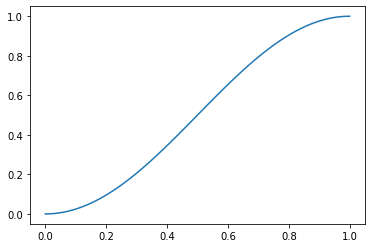

In [130]:
xc = np.array(gen_chord_points(n))
xe = np.linspace(0.0,1.0,n+1)
plt.plot(xe,xc)

The slope of this curve indicates how the points are grouped. Points will closer together near the leading and trailing edges, and more evenly spread out over the center section. This distribution can help with analytical schemes we used to assess the airfoil.

### Local Thickness

Now, we set up a function that will determine the local thickness along the chord line. We provide a parameter that will control the trailing edge closing condition:

In [131]:
def thickness(x, closed_te = True):
    """return yt array for input x array"""
    n = len(x)
    a0 = +0.2969
    a1 = -0.1260
    a2 = -0.3516
    a3 = +0.2843
    if closed_te:
        a4 = -0.1036 # For finite thick TE
    else:
        a4 = -0.1015 # For zero thick TE

    yt = 5*t*(a0*np.sqrt(x)+((((a4)*x+a3)*x+a2)*x+a1)*x)
    return yt

As a check, let's plot this thickness distribution for a 2414 airfoil:

In [132]:
yt = thickness(xc)

Now, we set up a plotting function to display the points:

In [133]:

def plotline(x,y):
    plt.figure(figsize=(10,1.6))
    plt.xlim(-0.2, 1.1)
    plt.ylim(-0.2, t + 0.1)
    plt.axis("equal")
    plt.axis((-0.1,1.1)+plt.axis()[2:])
    plt.plot(x,y)
    plt.show()

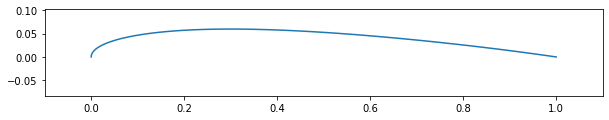

In [134]:
plotline(xc,yt)

### Define the Camber Line

In [135]:
def get_camber_line(xc, m, p, t):
    n = len(xc)
    
    # generate the slopes
    if p == 0:
        # symmetric airfoil
        yc = np.zeros(n)
    else:
        # split the chordwise points at the max thickness point
        x1 = [x for x in xc if x <= p]
        x2 = [x for x in xc if x > p]
        yc1 = [m/(p**2)*x*(2*p-x) for x in x1]
        yc2 = [m/(1-p)**2*(1-2*p+x)*(1-x) for x in x2]
        yc = yc1 + yc2

        return yc

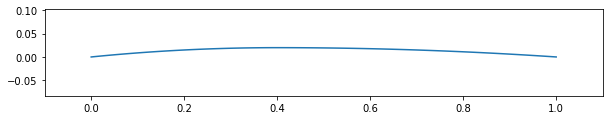

In [136]:
yc = get_camber_line(xc, m, p, t)
plotline(xc,yc)

### Camber Line Slopes

Now we are ready to calculate the upper and lower surface values:

In [173]:
def get_camber_line_slope(xc, m, p, t):
    n = len(xc)
    
    # generate the slopes
    if p == 0:
        # symmetric airfoil
        theta = np.zeros(n)
    else:
        # split the chordwise points at the max thickness point
        x1 = [x for x in xc if x <= p]
        x2 = [x for x in xc if x > p]

        dyc1_dx = [m/(p**2)*(2*p-2*x) for x in x1]
        dyc2_dx = [m/(1-p)**2*(2*p-2*x) for x in x2]
        dyc_dx = dyc1_dx + dyc2_dx
        theta = np.arctan(dyc_dx)
        return theta

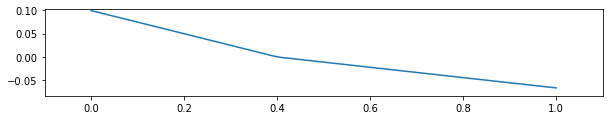

In [174]:
theta = get_camber_line_slope(xc, m, p, t)
plotline(xc,theta)

### Generating Surface Points

With the camber line and its slopes defined, we can position the surface points. These use the slopes to set the direction of the normal to the *camber line*

In [144]:
def gen_surface(xc, yc, yt, theta):
    xu = xc - yt*np.sin(theta)
    yu = yc + yt*np.cos(theta)
    xl = xc + yt*np.sin(theta)
    yl = yc - yt*np.cos(theta)
    return xu, yu, xl, yl

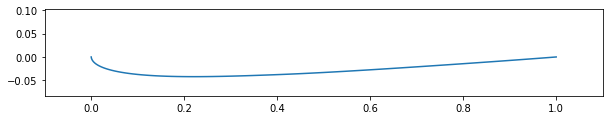

In [145]:
xu, yu, xl, yl = gen_surface(xc, yc, yt, theta)
plotline(xl,yl)

In [148]:
def plotairfoil(xu,yu, xl, yl, xc, yc):
    plt.figure(figsize=(10,1.6))
    plt.xlim(-0.2, 1.1)
    plt.ylim(-0.2, t + 0.1)
    plt.axis("equal")
    plt.axis((-0.1,1.1)+plt.axis()[2:])
    plt.plot(xu,yu)
    plt.plot(xc,yc)
    plt.plot(xl,yl)
    plt.show()

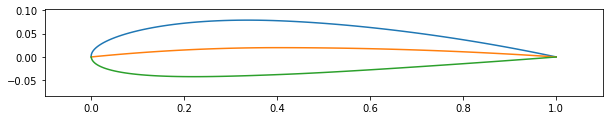

In [149]:
plotairfoil(xu, yu, xl, yl, xc, yc)

## NACA4 Class

To complete this project, we will generate a *Python* class that includes all of this code and eliminates duplication. The class will be able to return the variious curves we generated for use in studies.

Note that I need to show the complete class in one chunk, since Jupyter will not build up a class incrementally :-(

In [181]:
import numpy as np

class NACA4(object):
    
    def __init__(self, name, npoints, closed_te = True, cosine_pts = True):
        self.name = name
        self.npoints = npoints
        self.closed_te = closed_te
        self.cosine_pts = cosine_pts
        

        
        # decode the name
        self.m = int(name[0])/100
        self.p = int(name[1])/10
        self.t = int(name[2:])/100
        
    def generate(self):
        self.gen_xc_points()
        self.gen_thickness()
        self.gen_camber_line()
        self.gen_camber_line_slopes()
        self.gen_surface()
    
    def gen_xc_points(self):
        if self.cosine_pts:
            # distribute x points closer to nose
            beta = np.linspace(0.0,math.pi,n+1)
            self.xc = 0.5*(1.0 - np.cos(beta))  # cosine based spacing
        else:
            # linear distribution
            self.xc = np.linspace(0.0,1.0,n+1)
            
    def get_xc_points(self):
        return self.xc

    def gen_thickness(self):
        """generate yt array for xc array"""
        a0 = +0.2969
        a1 = -0.1260
        a2 = -0.3516
        a3 = +0.2843
        
        x = self.xc
        if self.closed_te:
            a4 = -0.1036 # For finite thick TE
        else:
            a4 = -0.1015 # For zero thick TE

        self.yt = 5*t*(a0*np.sqrt(x)+((((a4)*x+a3)*x+a2)*x+a1)*x)
    
    def get_thickness(self):
        return self.yt
    
    def gen_camber_line(self):
        if self.p == 0:
            # symmetric airfoil
            self.yc = np.zeros(n)
        else:
            # split the chordwise points at the max thickness point
            x1 = [x for x in self.xc if x <= self.p]
            x2 = [x for x in self.xc if x > self.p]
            yc1 = [self.m/(self.p**2)*x*(2*self.p-x) for x in x1]
            yc2 = [self.m/(1-self.p)**2*(1-2*self.p+x)*(1-x) for x in x2]
            
            # save for later
            self.x1 = x1
            self.x2 = x2
            
            self.yc = np.array(yc1 + yc2)
        
    def get_camber_line(self):
        return self.yc
    
    def gen_camber_line_slopes(self):
        if self.p == 0:
            # symmetric airfoil
            theta = np.zeros(self.npoints)
        else:
            dyc1_dx = [self.m/(self.p**2)*(2*p-2*x) for x in self.x1]
            dyc2_dx = [self.m/(1-self.p)**2*(2*self.p-2*x) for x in self.x2]
            dyc_dx = dyc1_dx + dyc2_dx
            theta = np.arctan(dyc_dx)
        self.theta = theta
            
    def get_camber_line_slopes(self):
        return self.theta
    
    def gen_surface(self):
        self.xu = self.xc - self.yt*np.sin(self.theta)
        self.yu = self.yc + self.yt*np.cos(self.theta)
        self.xl = self.xc + self.yt*np.sin(self.theta)
        self.yl = self.yc - self.yt*np.cos(self.theta)
        
    def get_surface(self):
        return self.xu, self.yu, self.xl, self.yl

Let's test this class and display the airfoil again:

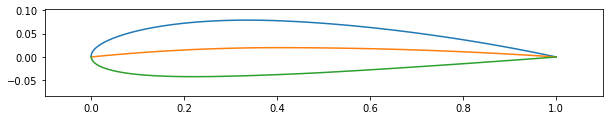

In [182]:
af = NACA4('2412',100)
af.generate()
txu, tyu, txl, tyl  = af.get_surface()
txc = af.get_xc_points()
tyc = af.get_camber_line()
plotairfoil(txu, tyu, txl, tyl, txc, tyc)